In [ ]:
import numpy as np
import math
import heapq

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import matplotlib.pyplot as plt
from a_star import *
import pickle
from shapely.geometry import Polygon, LineString
from shapely.geometry import Point
from magic import ordinator
import cv2
from scipy import ndimage

In [ ]:
with open("SLAM20240204_160029.pickle", 'rb') as input_file:
# with open(r"SLAM20240124_162059.pickle", "rb") as input_file:
# with open(r"SLAM20240121_162038.pickle", "rb") as input_file:
# with open(r"SLAM20240124_162059.pickle", "rb") as input_file:

    e = pickle.load(input_file)

positions = np.array(e['positions'])
ids = e['ids']
ids = np.array(ids)
robot_pose=e['robot_pose']

for i, pos_zip in enumerate(zip(positions, ids)):
    col = pos_zip[1] % 3
    if col == 0:
        col2 = 'green'
    elif col == 1:
        col2 = 'red'
    elif col == 2:
        col2 = 'blue'
    if pos_zip[1] < 100:
        col2 = 'black'
    plt.scatter(*pos_zip[0], color=col2)

plt.scatter(*robot_pose, color='orange')
# plt.scatter(0, 0, color='orange', marker='3',)
plt.gca().set_aspect('equal')
plt.show()


positions_array = np.array(positions)

mask_external = (ids % 3 == 2) & (ids >= 100) & (ids <= 1000)
mask_internal = (ids % 3 == 0) & (ids >= 100) & (ids <= 1000)
mask_obstacle = (ids % 3 == 1) & (ids >= 100) & (ids <= 1000)
mask_start_line = (ids < 100)


ids_external = ids[mask_external]
ids_internal = ids[mask_internal]

positions_external = positions_array[mask_external]
positions_internal = positions_array[mask_internal]
positions_obstacle = positions_array[mask_obstacle]
positions_start_line = positions_array[mask_start_line]

In [3]:
pos_list_ext = [pos for pos in positions_external]
pos_list_int = [pos for pos in positions_internal]

external_ordered = np.array(ordinator(pos_list_ext, max_distance=0.6))
internal_ordered = np.array(ordinator(pos_list_int))

spatial_step = 0.05
max_x = np.max(external_ordered[:, 0])
max_y = np.max(external_ordered[:, 1])
min_x = np.min(external_ordered[:, 0])
min_y = np.min(external_ordered[:, 1])
delta_x = max_x-min_x
delta_y = max_y-min_y
center_x = min_x+delta_x/2
center_y = min_y+delta_y/2

n_x = int(delta_x/spatial_step)
n_y = int(delta_y/spatial_step)

ext_ordered_poly = Polygon(external_ordered)
int_ordered_poly = Polygon(internal_ordered)


x = np.linspace(min(np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), max(
    np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), n_x)
y = np.linspace(min(np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), max(
    np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), n_y)
X, Y = np.meshgrid(x, y)

# Create a mask where the pixels inside the first circle and outside the second circle are set to 1, and all others are set to 0
mask_internal = np.array([[int_ordered_poly.contains(
    Point(x[i], y[j])) for i in range(len(x))] for j in range(len(y))])
mask_external = np.array([[not ext_ordered_poly.contains(
    Point(x[i], y[j])) for i in range(len(x))] for j in range(len(y))])

mask_internal=ndimage.binary_dilation(mask_internal, iterations=2)
# mask_internal=1-mask_tmp
mask=mask_internal+ mask_external
# plt.imshow(mask, origin='lower')

In [4]:
mask_line_obs=np.zeros_like(mask, dtype=bool)
for x_i,y_i in np.vstack((positions_start_line, positions_obstacle)):
    mask_line_obs += np.array([[Point(x_i,y_i).buffer(0.1).contains(Point(x[i], y[j]))
                for i in range(len(x))] for j in range(len(y))])

mask=mask+mask_line_obs

# Compute the matrix coordinates

In [5]:

def geometry_to_matrix(robot_pose, external_ordered, spatial_step):
    x,y=robot_pose
    min_x = np.min(external_ordered[:, 0])
    min_y = np.min(external_ordered[:, 1])
    index_x = int(abs(min_x-x)/spatial_step)
    index_y = int(abs(min_y-y)/spatial_step)
    return (index_x, index_y)

start=geometry_to_matrix(robot_pose, external_ordered, spatial_step)
start

(33, 9)

# Find start and end points

In [6]:
def find_extremes(ids, positions):
    mask_start_line = (ids < 100) & (ids > 0)
    positions_start_line = positions[mask_start_line]
    pos_start_line_ordered = np.array(
        ordinator(positions_start_line, max_distance=0.3))
    first = pos_start_line_ordered[0]
    last = pos_start_line_ordered[-1]

    radius = np.sqrt((first[0]-last[0])**2+(last[1]-first[1])**2)*0.75

    return (first, last, radius)

def get_centers(first, last, r):
    x1, y1 = first
    x2, y2 = last
    r1 = r2 = r
    centerdx = x1 - x2
    centerdy = y1 - y2
    R = np.sqrt(centerdx**2 + centerdy**2)
    if not (abs(r1 - r2) <= R and R <= r1 + r2):
        """ No intersections """
        return []

    """ intersection(s) should exist """
    R2 = R**2
    R4 = R2**2
    a = (r1**2 - r2**2) / (2 * R2)
    r2r2 = r1**2 - r2**2
    c = np.sqrt(2 * (r1**2 + r2**2) / R2 - (r2r2**2) / R4 - 1)

    fx = (x1 + x2) / 2 + a * (x2 - x1)
    gx = c * (y2 - y1) / 2
    ix1 = fx + gx
    ix2 = fx - gx

    fy = (y1 + y2) / 2 + a * (y2 - y1)
    gy = c * (x1 - x2) / 2
    iy1 = fy + gy
    iy2 = fy - gy

    return [np.array([ix1, iy1]), np.array([ix2, iy2])]

def get_arrival_coords(robot_pose, ids, positions):
    intersect_1, intersect_2 = get_centers(*find_extremes(ids, positions))
    d1 = np.sqrt(np.sum((robot_pose-intersect_1)**2))
    d2 = np.sqrt(np.sum((robot_pose-intersect_2)**2))

    if d1 < d2:
        target_start = intersect_1
        target_end = intersect_2
    else:
        target_start = intersect_2
        target_end = intersect_1

    return target_start, target_end


start, end = get_arrival_coords(robot_pose, ids, positions)

In [7]:
initial_race=geometry_to_matrix(start, external_ordered, spatial_step)
start_race=geometry_to_matrix(end, external_ordered, spatial_step)

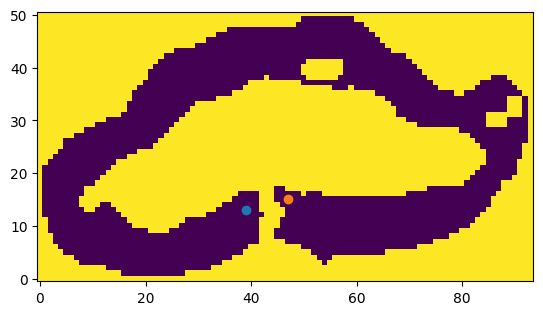

In [8]:
plt.imshow(mask, origin='lower')
# plt.scatter(*start)
plt.scatter(*initial_race)
plt.scatter(*start_race)


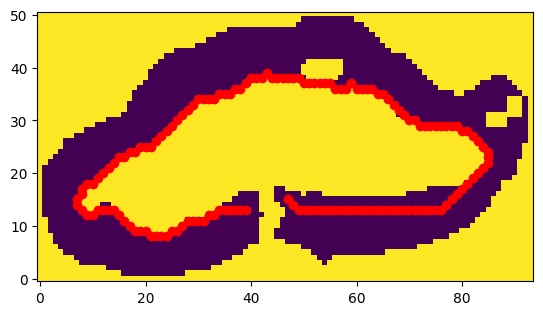

[(47, 15), (48, 14), (49, 13), (50, 13), (51, 13), (52, 13), (53, 13), (54, 13), (55, 13), (56, 13), (57, 13), (58, 13), (59, 13), (60, 13), (61, 13), (62, 13), (63, 13), (64, 13), (65, 13), (66, 13), (67, 13), (68, 13), (69, 13), (70, 13), (71, 13), (72, 13), (73, 13), (74, 13), (75, 13), (76, 13), (77, 14), (78, 15), (79, 16), (80, 17), (81, 18), (82, 19), (83, 20), (84, 21), (85, 22), (85, 23), (85, 24), (84, 25), (83, 26), (82, 27), (81, 28), (80, 28), (79, 29), (78, 29), (77, 29), (76, 29), (75, 29), (74, 29), (73, 29), (72, 29), (71, 30), (70, 30), (69, 31), (68, 32), (67, 33), (66, 34), (65, 35), (64, 35), (63, 36), (62, 36), (61, 36), (60, 36), (59, 37), (58, 36), (57, 36), (56, 36), (55, 37), (54, 37), (53, 37), (52, 37), (51, 37), (50, 37), (49, 38), (48, 38), (47, 38), (46, 38), (45, 38), (44, 38), (43, 39), (42, 38), (41, 38), (40, 38), (39, 37), (38, 36), (37, 36), (36, 35), (35, 35), (34, 35), (33, 34), (32, 34), (31, 34), (30, 34), (29, 33), (28, 32), (27, 31), (26, 30),

In [9]:
maze_plot(mask, start_race, initial_race)

In [10]:
path_to_follow=astar(mask, start_race, initial_race)

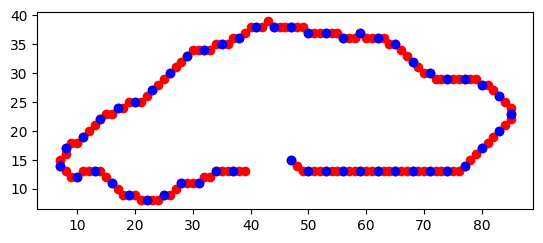

In [11]:
for point in path_to_follow:
    plt.scatter(*point, c='red')

for point in path_to_follow[::3]:
    plt.scatter(*point, c='blue')

plt.gca().set_aspect('equal')